# <span style="color:#F72585"><center>Introducción a Modelos Secuenciales</center></span>

## <span style="color:#4361EE">Herramientas básicas de programación</span>

Adaptadas del texto [Dive into Deep learning](https://d2l.ai/).

### <span style="color:#4CC9F0">Importa módulos</span>


In [1]:
#import collections
#from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import os
import pandas as pd
import random
#import re
#import shutil
import sys
#import tarfile
#import time
#import requests
#import zipfile
#import hashlib

import numpy as np
import tensorflow as tf

%matplotlib inline

# Alias
size = lambda a: tf.size(a).numpy()

c:\Users\User\anaconda3\envs\work\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### <span style="color:#4CC9F0">Clase Acumulador para evaluar funciones de pérdida</span>


In [2]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


### <span style="color:#4CC9F0">Utilitarios para preparar  datos en Tensorflow</span>


In [3]:
    
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

### <span style="color:#4CC9F0">Función genérica para calcular funciones de pérdida</span>


In [4]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), size(l))
    return metric[0] / metric[1]

### <span style="color:#4CC9F0">Funciones gráficas utilitarias</span>


In [5]:
import numpy as np
import tensorflow as tf


# Defined in file: ./chapter_preliminaries/calculus.md
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


# Defined in file: ./chapter_preliminaries/calculus.md
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


# 
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


# 
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)


## <span style="color:#4361EE">Introducción</span>

Los datos de la serie temporal introducen una "dependencia dura" de los pasos de tiempo anteriores, por lo que no se cumple la independencia de las observaciones. Podemos entonces preguntarnos ¿Cuáles son algunas de las propiedades que puede tener una serie temporal?

La *estacionalidad* y la *autocorrelación* son algunas de las propiedades de la serie temporal en las que puede estar interesado. 
Se dice que una serie de tiempos es **estacionaria** cuando la media y la varianza permanecen constantes en el tiempo. Una serie temporal tiene una **tendencia** si la media varía con el tiempo. A menudo es posible eliminar la tendencia y hacer que la serie sea estacionaria aplicando transformación(es) logarítmicas de los datos.


**La estacionalidad** se refiere al fenómeno de las variaciones en plazos específicos. Por ejemplo, las personas compran más árboles de Navidad durante Navidad (quién lo hubiera pensado). Un enfoque común para eliminar la estacionalidad es usar la diferenciación. **La autocorrelación** se refiere a la correlación entre el valor actual con una copia de un tiempo anterior (retraso).  

En este tratado usaremos redes neuronales para la modelación de las series.


## <span style="color:#4361EE">Herramientas estadísticas</span>

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Redes_Recurrentes/Imagenes/ftse100.png" width="500" height="400" align="right"/>
</center>
</figure>

Necesitamos herramientas estadísticas y nuevas arquitecturas de redes neuronales profundas para manejar datos de secuencia. Para simplificar las cosas, usamos el precio de las acciones (índice FTSE 100) ilustrado en la siguiente figura.

Denotemos los precios por $ x_t $, es decir, en el *tiempo* $ t \in \mathbb{Z}^+$ observamos el precio $ x_t $. 
Tenga en cuenta que para las secuencias de texto, $ t $ normalmente será discreto y variará en el conjunto de los números enteros o en subconjunto de este. Supongamos que deseamos predecir el precio de la acción para el día $ t $ mediante $ x_t $ a través de

$$ x_t \sim P (x_t \mid x_ {t-1}, \ldots, x_1). $$

### <span style="color:#4CC9F0">Modelos Autorregresivos</span>


Para lograr esto, podríamos usar un modelo de regresión como los que entrenamos previamente. Recuerde el ejemplo de predicción de consumo de gasolina o la tarea de predicción del valor de las casas de Boston. Solo hay un problema importante: el número de entradas, $ x_{t-1}, \ldots, x_1 $ varía, dependiendo de $ t $. Es decir, el número aumenta con la cantidad de datos que encontramos, y necesitaremos una aproximación para que esto sea computacionalmente manejable.


Gran parte de lo que sigue en esta introducción a redes recurrentes girará en torno a cómo estimar $ P (x_t \mid x_{t-1}, \ldots, x_1) $ de manera eficiente. En pocas palabras, nuestras estrategias se reducen a dos técnicas de la siguiente manera.

Primero, suponga que la secuencia potencialmente bastante larga $ x_{t-1}, \ldots, x_1 $ no es realmente necesaria. En este caso, podríamos contentarnos con un período de tiempo de longitud $ \tau $ y solo usar observaciones $ x_{t-1}, \ldots, x_ {t- \tau} $.

El beneficio inmediato es que ahora el número de argumentos es siempre el mismo, al menos para $ t> \tau $. Esto nos permite entrenar una red profunda usando un modelo de regresión, en el cual se hace una regresión con los datos $ x_{t-1}, \ldots, x_ {t- \tau}$ para *predecir* $x_t$  . Dichos modelos se denominarán *modelos autorregresivos*, ya que literalmente realizan regresiones sobre sí mismos.


Para ilustrarlo, supongamos que tenemos la siguiente serie de datos 

$$[3.0, 2.1, 5.6, 4.2, 3.3, 4.2, 8.8, 4.5, 2.3, 5.1],$$

y definamos $ \tau =3$. Entonces el modelo de tipo autorregresivo se vería como sique:

|$x_1$|$x_2$|$x_3$|$y$|
|---|---|---|---|
|3.0| 2.1| 5.6| 4.2|
|2.1| 5.6| 4.2| 3.3|
|5.6| 4.2| 3.3| 4.2|
|4.2| 3.3| 4.2| 8.8|
|3.3| 4.2| 8.8| 4.2|
|4.2| 8.8| 4.5| 2.3|
|8.8| 4.5| 2.3| 5.1|



La segunda estrategia, que se muestra en la siguiente figura, es mantener un resumen $h_t$ de las observaciones pasadas y, al mismo tiempo, actualizar $h_t$ además de la predicción $ \hat{x}_t $.
Esto conduce a modelos que estiman $ x_t $ con $ \hat{x}_t = P (x_{t-1} \mid h_{t}) $ y además actualizaciones de la forma $ h_t = g (h_{t-1}, x_{t -1}) $. Dado que $ h_t $ nunca se observa, estos modelos también se denominan *modelos autorregresivos latentes*.

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Redes_Recurrentes/Imagenes/sequence-model.svg" width="300" height="300" align="right"/>
</center>
</figure>

Fuente: [Dive into Deep learning](https://d2l.ai/)

Ambos casos plantean la pregunta obvia de cómo generar datos de entrenamiento. Por lo general, se utilizan observaciones históricas para predecir la siguiente observación, dadas las que se han realizado hasta ahora. Evidentemente, no esperamos que el tiempo se detenga. Sin embargo, una suposición común es que si bien los valores específicos de $ x_t $ pueden cambiar, al menos la dinámica de la secuencia en sí no lo hará. Esto es razonable, ya que las dinámicas novedosas son solo eso, novedosas y, por lo tanto, no predecibles usando los datos que tenemos hasta ahora. 




Los estadísticos llaman a las dinámicas que no cambian *estacionarias*.
Independientemente de lo que hagamos, obtendremos una estimación de toda la secuencia a través de

$$ 
P (x_1, \ldots, x_T) = \prod_ {t = 1} ^ T P (x_t \mid x_ {t-1},  \ldots, x_1)
$$ .

Tenga en cuenta que las consideraciones anteriores siguen siendo válidas si tratamos con objetos discretos, como palabras, en lugar de números continuos. La única diferencia es que en tal situación necesitamos usar un clasificador en lugar de un modelo de regresión para estimar $ P (x_t \mid x_{t-1}, \ldots, x_1) $.

### <span style="color:#4CC9F0">Modelos de Markov</span>


Recuerde la aproximación de que en un modelo autorregresivo usamos solo $ x_ {t-1}, \ldots, x_ {t- \tau} $ en lugar de $ x_ {t-1}, \ldots, x_1 $ para estimar $ x_t $ . Siempre que esta aproximación sea precisa, decimos que la secuencia satisface una *condición de Markov*. En particular, si $\tau = 1$, tenemos un *modelo de Markov de primer orden* y $ P (x) $ viene dado por


$$ P (x_1, \ldots, x_T) = \prod_ {t = 1} ^ TP (x_t \mid x_ {t-1}). $$
en donde $P (x_1 \mid x_0) = P (x_1)$.

Tales modelos son particularmente agradables siempre que $ x_t $ asume solo un valor discreto, ya que en este caso la programación dinámica se puede usar para calcular valores a lo largo de la cadena exactamente. 

Por ejemplo, podemos calcular $ P (x_{t + 1} \mid x_ {t-1}) $ de manera eficiente:

$$ \begin{align*}
P (x_{t + 1} \mid x_{t-1})
& = \frac {\sum_{x_t} P (x_{t + 1}, x_t, x_{t-1})} {P (x_{t-1})} \\
& = \frac{\sum_{x_t} P (x_{t + 1} \mid x_t, x_{t-1}) P (x_t, x_{t-1})} {P (x_{t-1} )} \\
& = \sum_ {x_t} P (x_{t + 1} \mid x_t) P (x_t \mid x_{t-1}).
\end {align*}
$$

En la última ecuación hemos utilizado el hecho de que solo necesitamos tener en cuenta un historial  de la observación anterior, es decir,  $ P (x_{t + 1} \mid x_t, x_{t-1}) = P (x_{t + 1} \mid x_t) $.

Estas últimas ecuaciones se conocen como ecuaciones de `Chapman-Kolmogorov`. 

Entrar en detalles de la programación dinámica está más allá del alcance de este documento. Los algoritmos de control y aprendizaje por refuerzo utilizan estas herramientas de forma extensiva.

### <span style="color:#4CC9F0">Causalidad</span>


En principio, no hay nada de malo en desplegar $ P (x_1, \ldots, x_T) $ en orden inverso. Después de todo, condicionando siempre podemos escribirlo a través de

$$ P (x_1, \ldots, x_T) = \prod_ {t = T} ^ 1 P (x_t \mid x_ {t + 1}, \ldots, x_T). $$

De hecho, si tenemos un modelo de Markov, también podemos obtener una distribución de probabilidad condicional inversa. 

En muchos casos, sin embargo, existe una dirección natural para los datos, es decir, avanzar en el tiempo. Está claro que los eventos futuros no pueden influir en el pasado. Por lo tanto, si cambiamos $ x_t $, es posible que podamos influir en lo que sucede con $ x_{t + 1} $ en el futuro, pero no a la inversa. Es decir, si cambiamos $ x_t $, la distribución sobre eventos pasados no cambiará. En consecuencia, debería ser más fácil explicar $ P (x_{t + 1} \mid x_t) $ en lugar de $ P (x_t \mid x_{t + 1}) $. Por ejemplo, se ha demostrado que en algunos casos podemos encontrar $ x_{t + 1} = f (x_t) + \epsilon $ para algún ruido aditivo $ \epsilon $, mientras que lo contrario no es cierto.

## <span style="color:#4361EE">Entrenamiento</span>

### <span style="color:#4CC9F0">Generación de datos simulados (datos sintéticos)</span>


Comenzamos generando algunos datos.

Para simplificar las cosas, generamos nuestros datos de secuencia usando una función sinusoidal con algo de ruido aditivo para los pasos de tiempo $ 1, 2, \ldots, 1000 $.

C:\Users\User\AppData\Local\Temp\ipykernel_8408\3944349111.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


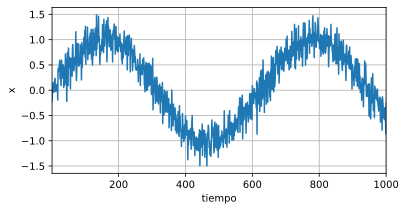

In [6]:
T = 1000  # Generate a total of 1000 points
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
plot(time, [x], 'tiempo', 'x', xlim=[1, 1000], figsize=(6, 3))

In [7]:
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i: T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

print(features.shape)
print(labels.shape)

(996, 4)
(996, 1)


In [8]:
it = iter(zip(features.numpy(), labels.numpy()))

In [9]:
for i in range(5):
    print(next(it))

(array([-0.2197726 , -0.05595977, -0.0465682 ,  0.14576076], dtype=float32), array([0.11138111], dtype=float32))
(array([-0.05595977, -0.0465682 ,  0.14576076,  0.11138111], dtype=float32), array([-0.0415264], dtype=float32))
(array([-0.0465682 ,  0.14576076,  0.11138111, -0.0415264 ], dtype=float32), array([0.03106181], dtype=float32))
(array([ 0.14576076,  0.11138111, -0.0415264 ,  0.03106181], dtype=float32), array([0.13232395], dtype=float32))
(array([ 0.11138111, -0.0415264 ,  0.03106181,  0.13232395], dtype=float32), array([0.19542366], dtype=float32))


In [10]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

### <span style="color:#4CC9F0">Define la red Vainilla que usaremos</span>


In [11]:
# Vanilla MLP architecture
def get_net():
    net = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'),
                              tf.keras.layers.Dense(1)])
    return net

# Least mean squares loss
# Note: L2 Loss = 1/2 * MSE Loss. TensorFlow has MSE Loss that is slightly
# different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
# value to get L2Loss in TF

### <span style="color:#4CC9F0">Define la función de pérdida</span>


In [12]:
loss = tf.keras.losses.MeanSquaredError()

### <span style="color:#4CC9F0">Entrenamiento</span>


In [13]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out) / 2
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.086153
epoch 2, loss: 0.065829
epoch 3, loss: 0.062928
epoch 4, loss: 0.059894
epoch 5, loss: 0.057622


## <span style="color:#4361EE">Predicción</span>

Dado que la pérdida de entrenamiento es pequeña, esperamos que nuestro modelo funcione bien. Veamos qué significa esto en la práctica. Lo primero que debe verificar es qué tan bien el modelo puede predecir lo que sucede en el siguiente paso de tiempo,
a saber, la *predicción de un paso adelante*.

C:\Users\User\AppData\Local\Temp\ipykernel_8408\3944349111.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


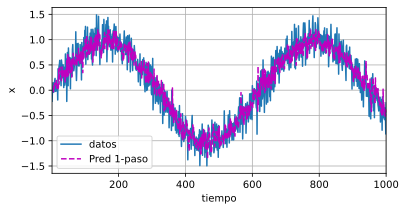

In [14]:
onestep_preds = net(features)
plot([time, time[tau:]], [x.numpy(), onestep_preds.numpy()],
         'tiempo',
         'x',
         legend=['datos', 'Pred 1-paso'],
         xlim=[1, 1000],
         figsize=(6, 3))

Las predicciones de un paso adelante se ven bien, tal como esperábamos.

Incluso más allá de 604 (`n_train + tau`) observaciones, las predicciones siguen pareciendo fiables.

Sin embargo, hay un pequeño problema en esto:

- si observamos datos de secuencia solo hasta el paso de tiempo 604, no podemos esperar recibir las entradas para todas las predicciones futuras de un paso adelante.

En cambio, tenemos que avanzar paso a paso:

$$\begin{align*}
\hat{x}_{605} &= f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} &= f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} &= f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
\end{align*}
$$

Generalmente, para una secuencia observada hasta $ x_t $, su salida predicha $ \hat{x}_{t + k} $ en el paso de tiempo $ t + k $ se llama *predicción $ k $-pasos adelante*. 

Como hemos observado hasta $ x_{604} $, su predicción $ k $-pasos adelante es $ \hat{x}_{604 + k} $.


En otras palabras, tendremos que usar nuestras propias predicciones para hacer predicciones de varios pasos hacia adelante.

Veamos qué tan bien va esto.

In [15]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))

C:\Users\User\AppData\Local\Temp\ipykernel_8408\3944349111.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


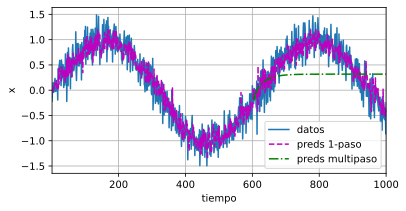

In [16]:
plot([time, time[tau:], time[n_train + tau:]], [
    x.numpy(),
    onestep_preds.numpy(), multistep_preds[n_train + tau:].numpy()
],
         'tiempo',
         'x',
         legend=['datos', 'preds 1-paso', 'preds multipaso'],
         xlim=[1, 1000],
         figsize=(6, 3))

Como muestra el ejemplo anterior, este es un fracaso espectacular. Las predicciones decaen a una constante bastante rápido después de algunos pasos de predicción.

¿Por qué funcionó tan mal el algoritmo?

En última instancia, esto se debe al hecho de que los errores se acumulan.

Digamos que después del paso 1 tenemos algún error $ \epsilon_1 = \bar \epsilon $.
Ahora la *entrada* para el paso 2 está perturbada por $ \epsilon_1 $, por lo tanto, sufrimos un error del orden de $ \epsilon_2 = \bar \epsilon + c \epsilon_1 $ para algunos $ c $ constantes, y así sucesivamente. 

El error puede diferir bastante rápidamente de las verdaderas observaciones. Este es un fenómeno común. Por ejemplo, los pronósticos meteorológicos para las próximas 24 horas tienden a ser bastante precisos, pero más allá de eso, la precisión disminuye rápidamente. Discutiremos métodos para mejorar esto a lo largo de este capítulo y más allá.

Echemos un vistazo más de cerca a las dificultades en las predicciones de $ k $ pasos adelante
calculando predicciones sobre la secuencia completa para $ k = 1, 4, 16, 64 $.


In [17]:
max_steps = 64

In [18]:
features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau: i])), -1))

C:\Users\User\AppData\Local\Temp\ipykernel_8408\3944349111.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


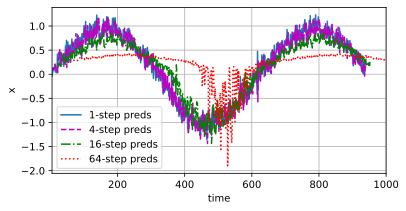

In [19]:
steps = (1, 4, 16, 64)
plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps],
         'time',
         'x',
         legend=[f'{i}-step preds' for i in steps],
         xlim=[5, 1000],
         figsize=(6, 3))

Esto ilustra claramente cómo cambia la calidad de la predicción a medida que intentamos predecir más en el futuro. Si bien las predicciones de 4 pasos adelante todavía se ven bien, cualquier cosa más allá de eso es casi inútil.

## <span style="color:#4361EE">Resumen</span>

* Existe una gran diferencia de dificultad entre la interpolación y la extrapolación. En consecuencia, si tiene una secuencia, siempre respete el orden temporal de los datos cuando entrene, es decir, nunca entrene con datos futuros.
* Los modelos de secuencia requieren herramientas estadísticas especializadas para la estimación. Dos opciones populares son los modelos autorregresivos y los modelos autorregresivos de variable latente.
* Para los modelos causales (por ejemplo, el tiempo en el futuro), estimar la dirección de avance suele ser mucho más fácil que la dirección inversa.
* Para una secuencia observada hasta el paso de tiempo $ t $, su salida predicha en el paso de tiempo $ t + k $ es la predicción de $ k $*- pasos adelante*. A medida que predecimos más en el tiempo aumentando $ k $, los errores se acumulan y la calidad de la predicción se degrada, a menudo de manera espectacular.

## <span style="color:#4361EE">Referencias</span>

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
2. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)
3. Basado en [Dive into Deep Learnig](https://d2l.ai/)